# Chapter 3: Generative Adversarial Networks (GANs): Shape and Pattern Generation




***
“Adversarial training (also called GAN for Generative Adversarial Networks), and the variations that are now being proposed, is the most interesting idea in the last 10 years in ML, in my opinion.”


-- Yann LeCun 
***



This chapter covers

* Creating a generator network and a discriminator network in GANs from scratch. 
* Using GANs to generate an inverted-U shape; generalizing the idea to other shapes. 
* Generating a sequence of integers that are all multiples of five.
* Learning how to train, save, reload, and use GANs. 
* Creatively formatting inputs in a way deep neural networks understand. 

Close to half of the generative models in this book belong to a framework called Generative Adversarial Networks (GANs). The framework was first proposed by Ian Goodfellow and his coauthors in 2014.  GANs, celebrated for their ease of implementation and versatility, empower individuals with even rudimentary knowledge of deep learning to construct their GANs from the ground up. The word "adversarial" in GAN refers to the fact that the two neural networks compete against each other in a zero-sum game framework: the generative network tries to create data instances indistinguishable from real samples, while the discriminative network tries to identify the generated samples from real ones. These versatile models can give rise to a plethora of creations, from geometric shapes and intricate patterns to high-quality color images like human faces, and even realistic-sounding musical compositions. 

This chapter introduces you to the basic idea behind GANs and you'll learn to use the framework to generate data samples that form an inverted-U shape in your first project. Armed with this skill, you'll be able to generate data to mimic any shape: sine, cosine, quadratic, and so on. The GANs framework can be applied to many different content formats and researchers have generated images, audio, music, video, and more by using the framework.

To make this point clear, in this chapter, you'll also learn how to use GANs to generate a sequence of numbers with certain patterns. As an example, you'll try to generate multiples of five as your second project in this chapter. But you can change the pattern to multiples of two, three, seven, …, and many other patterns.

While the steps involved in the second project are similar to those in the first project, the challenge is to format multiples of five in a way that neural networks understand. We’ll rely on the concept of one-hot encoding: creating a binary vector in which all values are zeros except in one position. To train GANs to generate a sequence of numbers that are multiples of five between 0 and 99, we break down an integer into the quotient and the remainder. We then use a 20-value one-hot variable to represent the quotient and a 5-value one-hot variable to represent the remainder. 

After this chapter, you'll be able to extend the idea behind GANs to other formats in later chapters, including high-resolution images and realistic-sounding music.

# 1. Introduction to Generative Adversarial Networks (GANs)

# 2.  GANs to Generate Shapes 

## 2.1. An Inverted-U Shape

In [1]:
import torch

torch.manual_seed(42)    #A

train_data = torch.zeros((2048, 2))    #B 

train_data[:,0]=10*(torch.rand(2048)-0.5)    #C

train_data[:,1]=10-train_data[:,0]**2    #D

We plot the relation between $x$ and $y$ by using the *matplotlib* library:

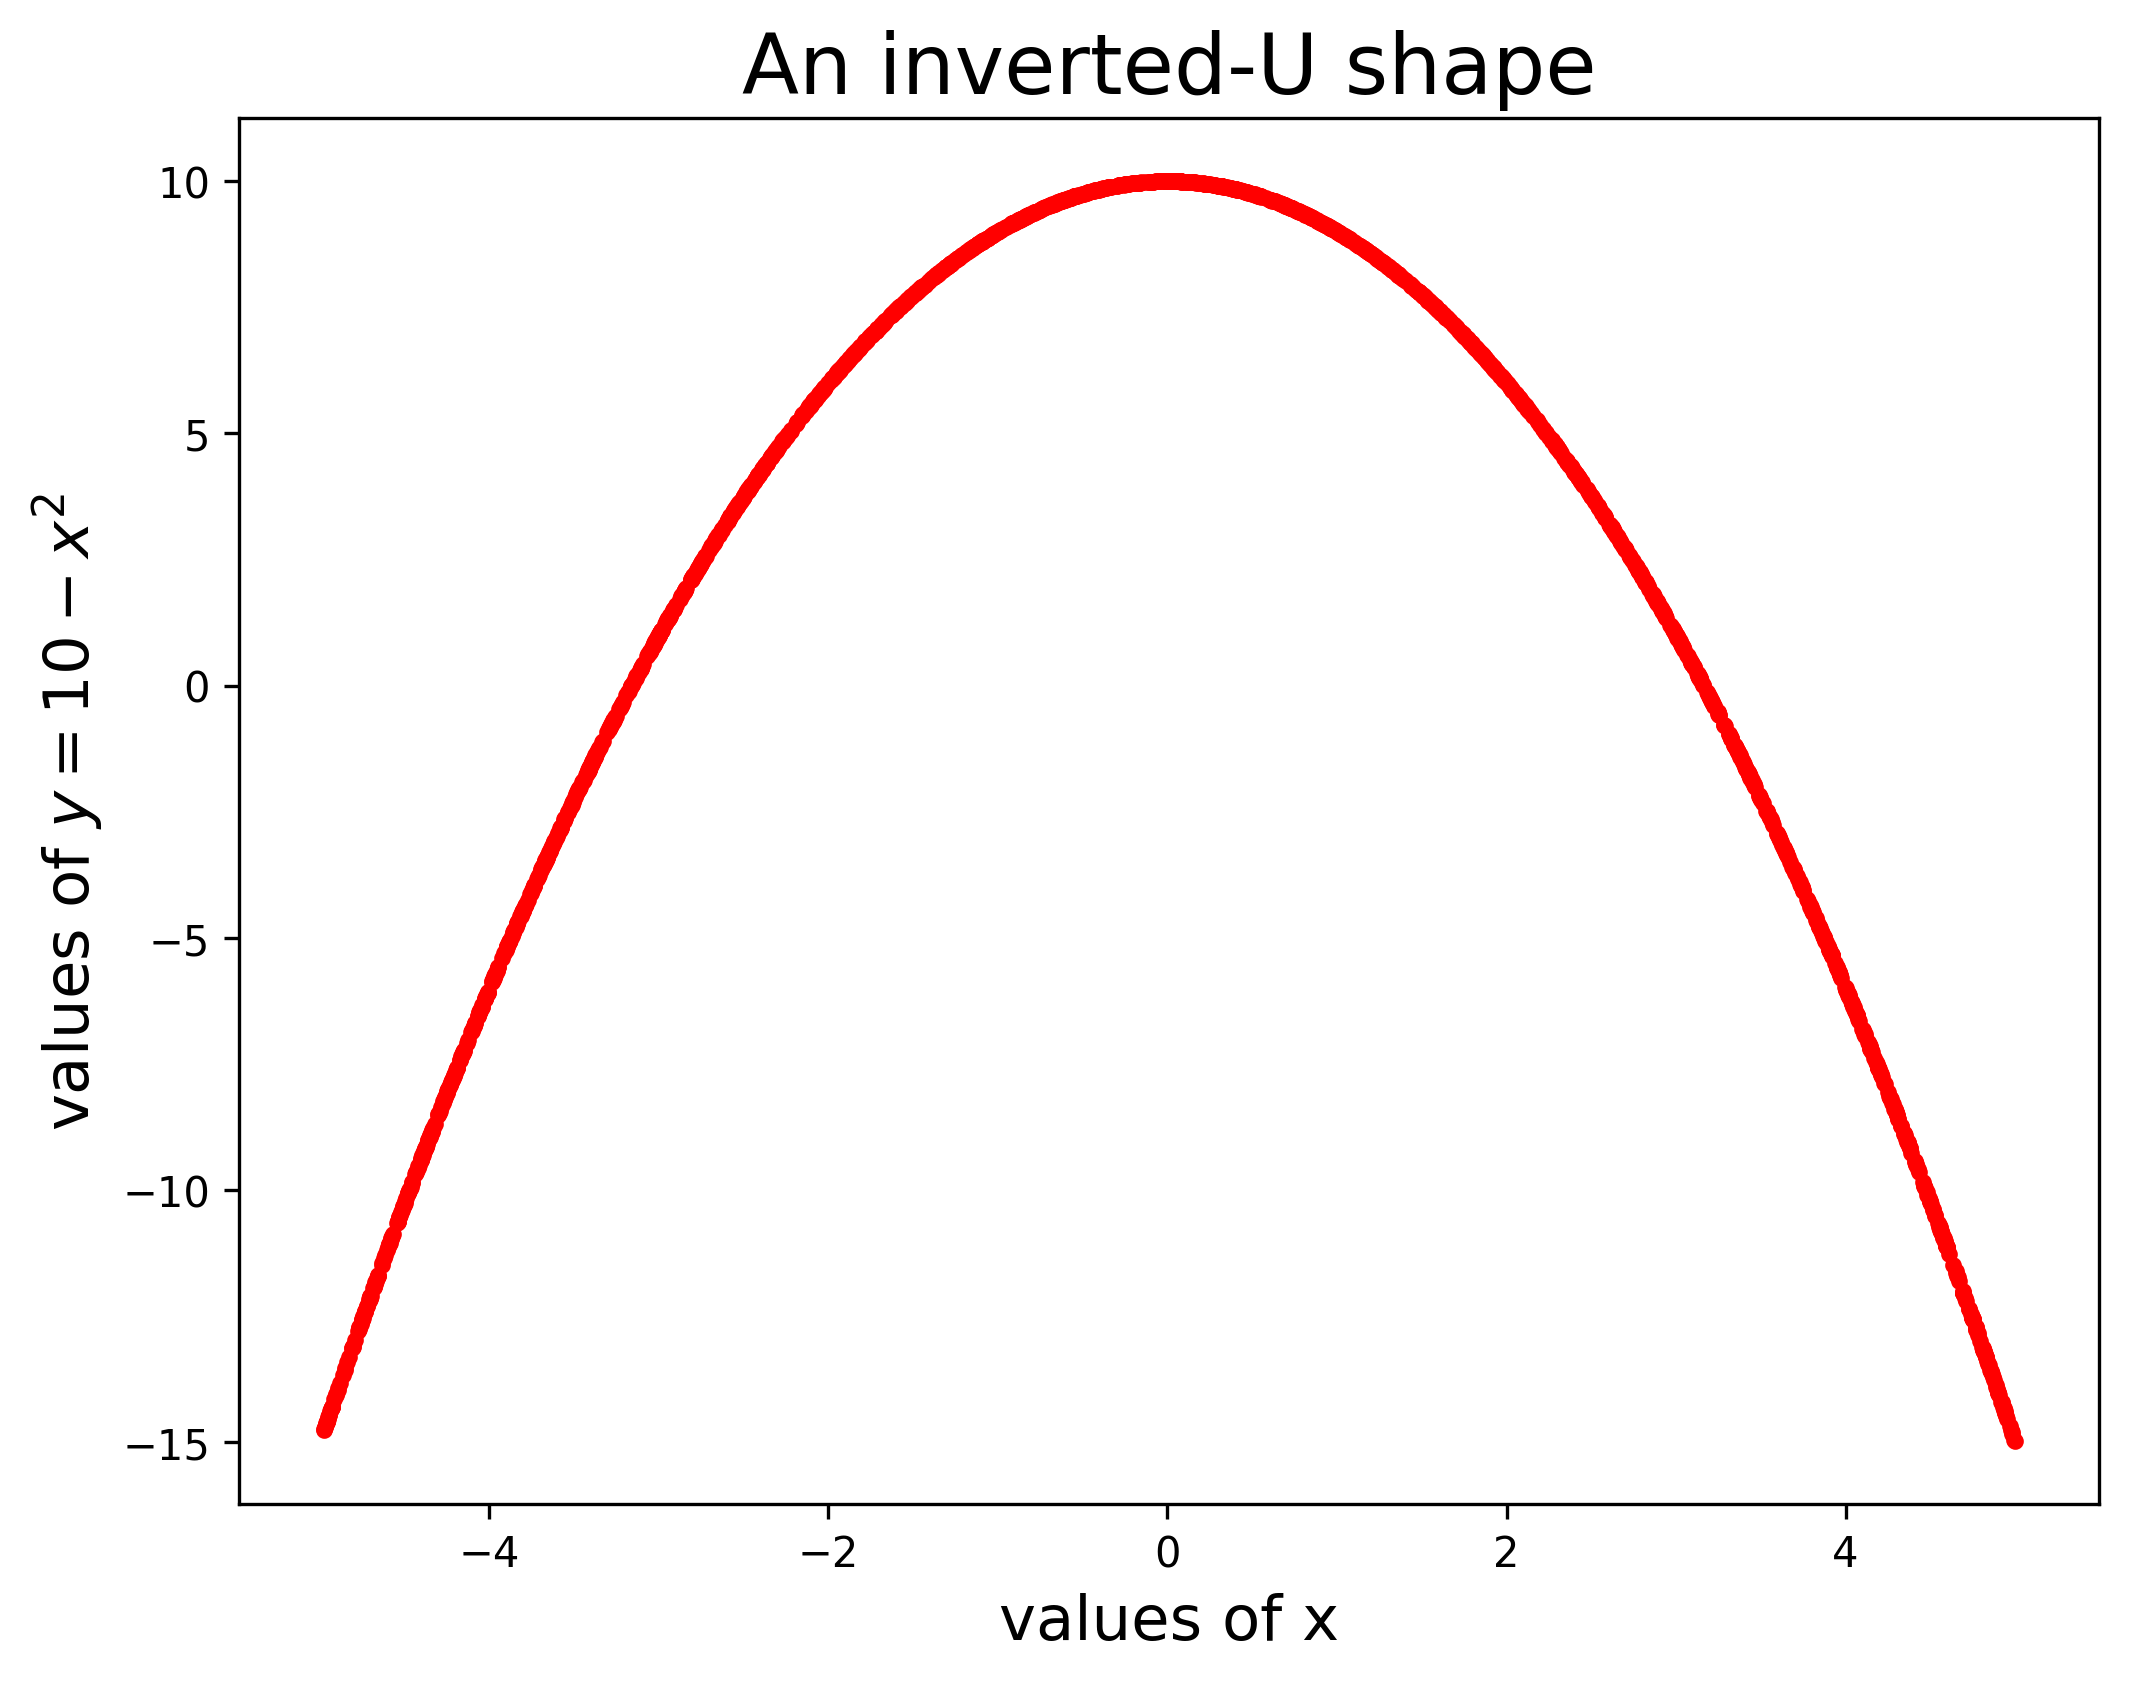

In [2]:
import matplotlib.pyplot as plt

fig=plt.figure(dpi=300,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")    #A
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=10-x^2$",fontsize=15)    #B
plt.title("An inverted-U shape",fontsize=20)    #C
plt.show()

The plot shows an inverted-U shape between $x$ and $y$. 

## 2.2. Preparing the Training Dataset

In [3]:
from torch.utils.data import DataLoader

batch_size=64
train_loader=DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True)

In [4]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[ 1.5716e+00,  7.5301e+00],
        [ 4.9019e+00, -1.4029e+01],
        [-5.6927e-01,  9.6759e+00],
        [-4.4646e+00, -9.9323e+00],
        [ 2.9225e+00,  1.4593e+00],
        [ 4.4632e+00, -9.9206e+00],
        [ 1.0771e+00,  8.8398e+00],
        [-2.4792e+00,  3.8536e+00],
        [ 2.7444e+00,  2.4684e+00],
        [-6.8983e-02,  9.9952e+00],
        [ 3.7938e+00, -4.3931e+00],
        [-4.4778e+00, -1.0051e+01],
        [ 4.8749e+00, -1.3764e+01],
        [ 4.6615e+00, -1.1730e+01],
        [ 2.9828e+00,  1.1029e+00],
        [ 3.3650e+00, -1.3233e+00],
        [ 1.6885e+00,  7.1489e+00],
        [-2.5821e+00,  3.3326e+00],
        [-1.8876e+00,  6.4371e+00],
        [ 2.8010e+00,  2.1544e+00],
        [ 4.5967e+00, -1.1129e+01],
        [-2.4968e+00,  3.7657e+00],
        [-4.6571e+00, -1.1689e+01],
        [-1.8513e+00,  6.5726e+00],
        [ 1.8621e+00,  6.5326e+00],
        [-6.4904e-01,  9.5787e+00],
        [ 2.3956e-01,  9.9426e+00],
        [-2.4403e+00,  4.045

## 2.3. Creating Generative Adversarial Networks (GANs)

In [5]:
import torch.nn as nn

device="cuda" if torch.cuda.is_available() else "cpu"

D=nn.Sequential(
    nn.Linear(2,256),    #A
    nn.ReLU(),
    nn.Dropout(0.3),    #B
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),    #C
    nn.Sigmoid()).to(device)

In [6]:
G=nn.Sequential(
    nn.Linear(2,16),    #A
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device)    #B

In [7]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

# 3. Train and Use GANs for Shape Generation

## 3.1. Train the GANs

In [8]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [9]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    optimD.zero_grad()
    out_D=D(real_samples)    #A
    loss_D=loss_fn(out_D,real_labels)    #B
    loss_D.backward()
    optimD.step()    #C
    return loss_D

In [10]:
def train_D_on_fake():        
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    fake_samples=G(noise)     #A       
    optimD.zero_grad()
    out_D=D(fake_samples)    #B
    loss_D=loss_fn(out_D,fake_labels)    #C
    loss_D.backward()
    optimD.step()    #D
    return loss_D

In [11]:
def train_G(): 
    noise=torch.randn((batch_size,2))
    noise=noise.to(device)
    optimG.zero_grad()
    fake_samples=G(noise)    #A
    out_G=D(fake_samples)    #B
    loss_G=loss_fn(out_G,real_labels)    #C
    loss_G.backward()
    optimG.step()     #D
    return loss_G, fake_samples 

In [12]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch}, G loss: {g}, D loss {d}")    #B 
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(-6,6)
        plt.ylim(-16,11)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.jpg")
        plt.show()

at epoch 0, G loss: 0.7736166061893586, D loss 0.8281744064823273


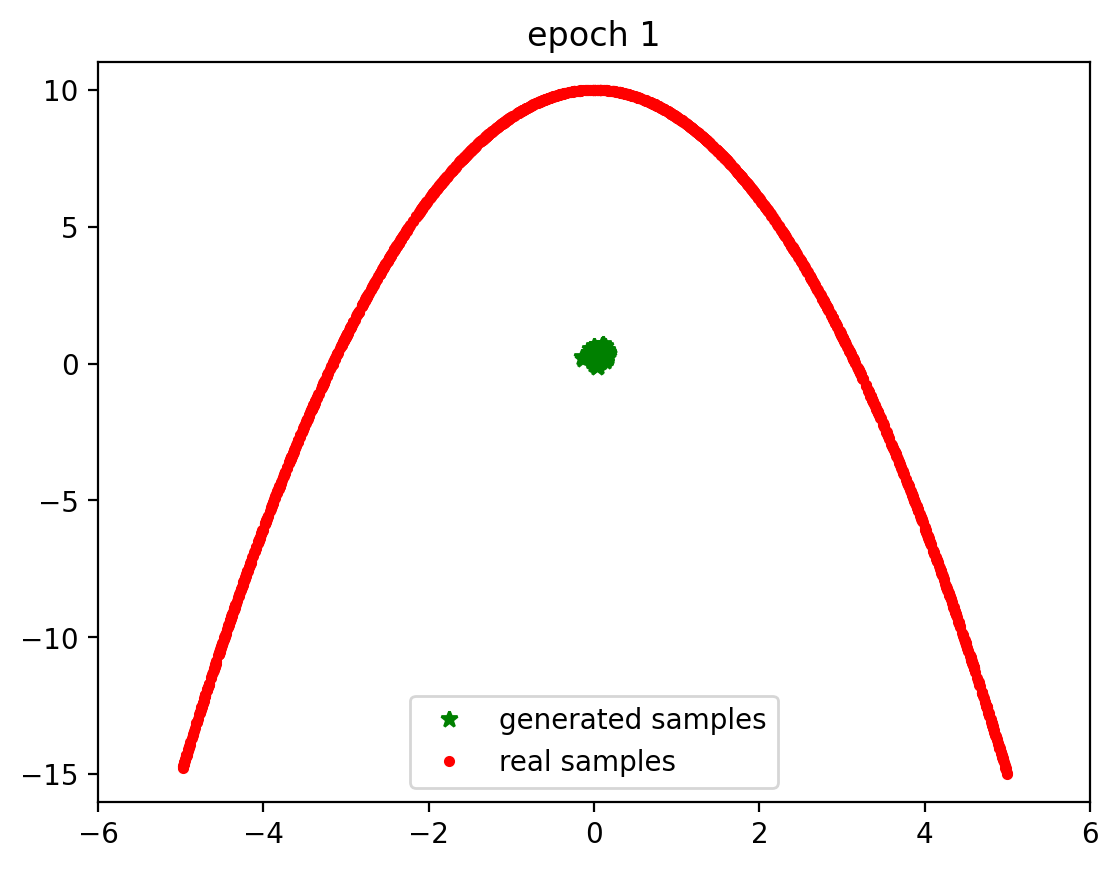

at epoch 24, G loss: 1.1048807944020917, D loss 1.0415202725318171


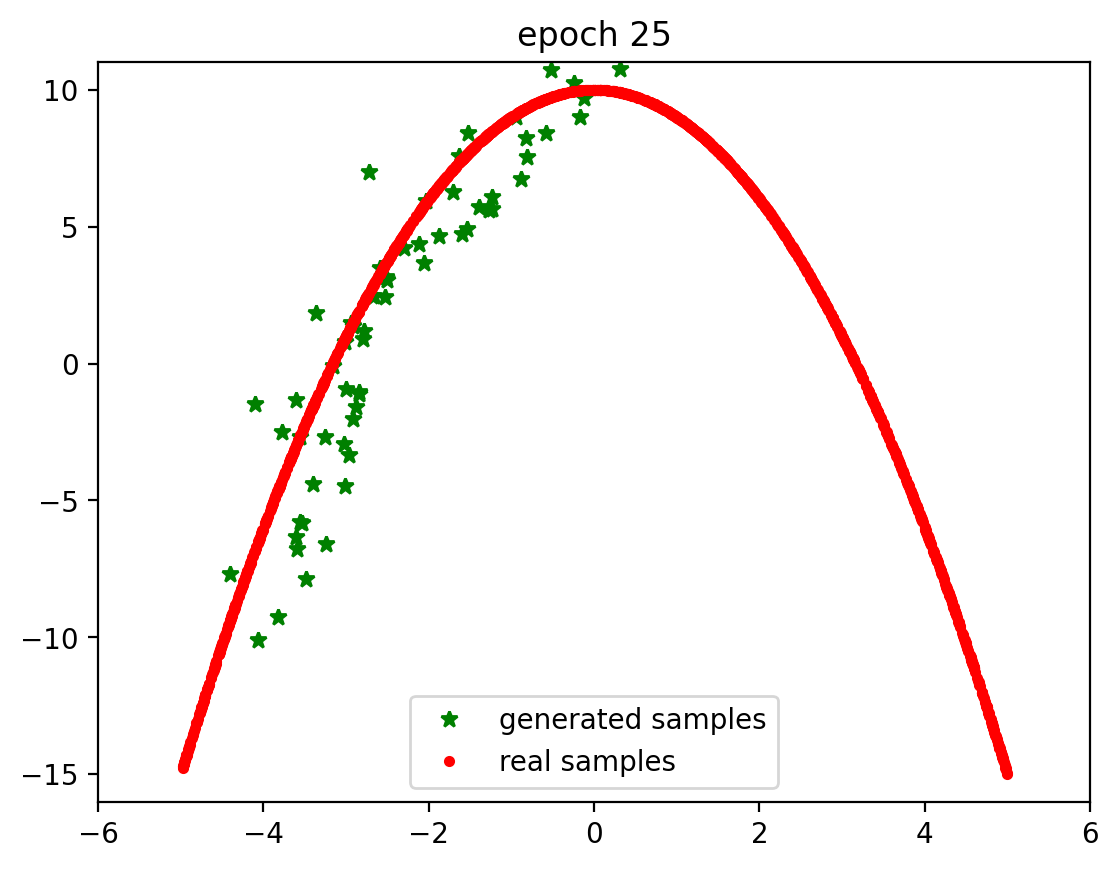

at epoch 49, G loss: 1.0869790354082662, D loss 1.0768288643129411


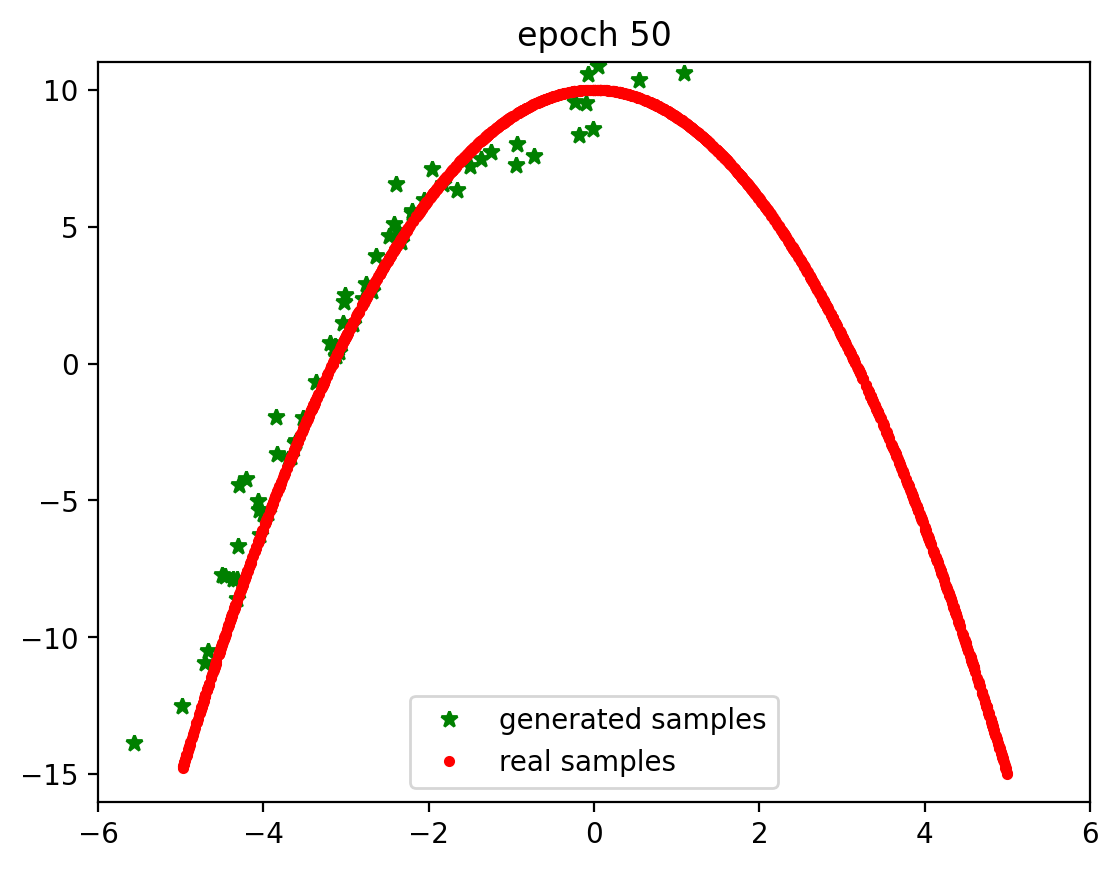

at epoch 74, G loss: 1.0606986015073714, D loss 1.0731885356287802


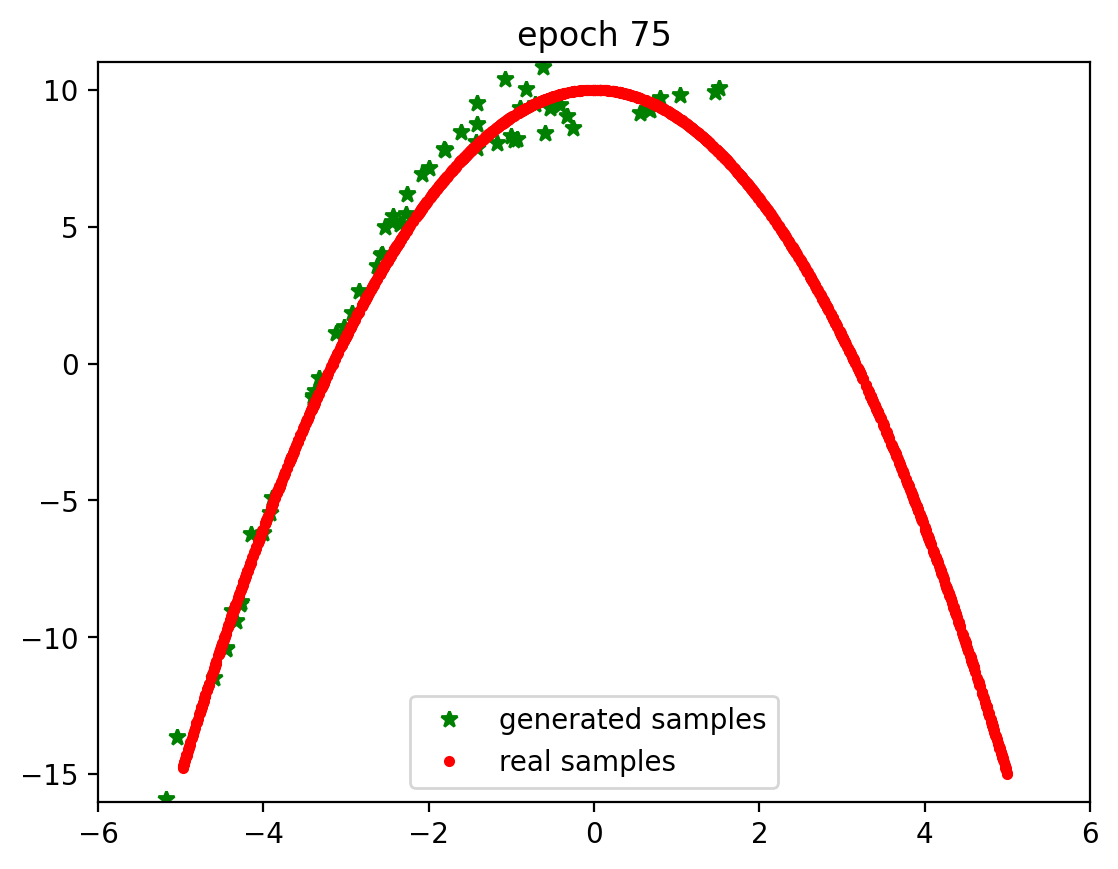

at epoch 99, G loss: 1.0030668320194367, D loss 1.1606818168394026


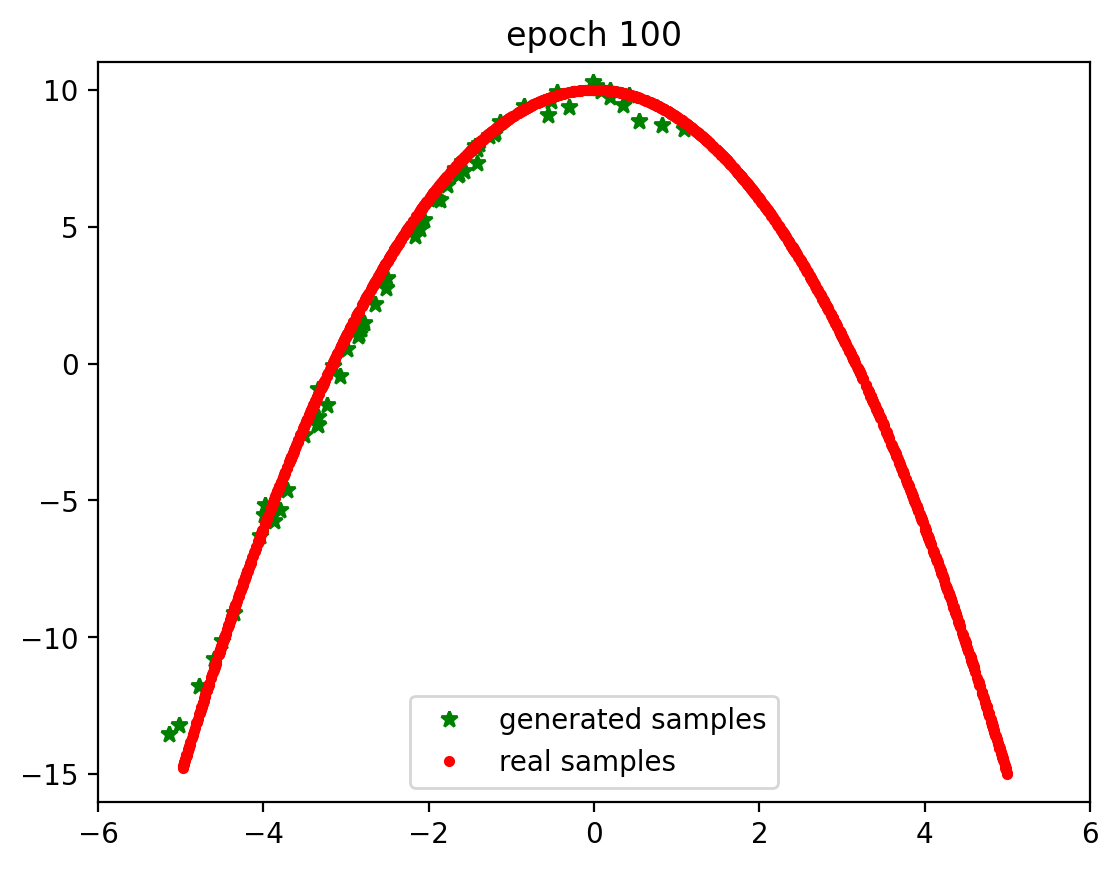

at epoch 124, G loss: 0.8980745500133883, D loss 1.2388535776445944


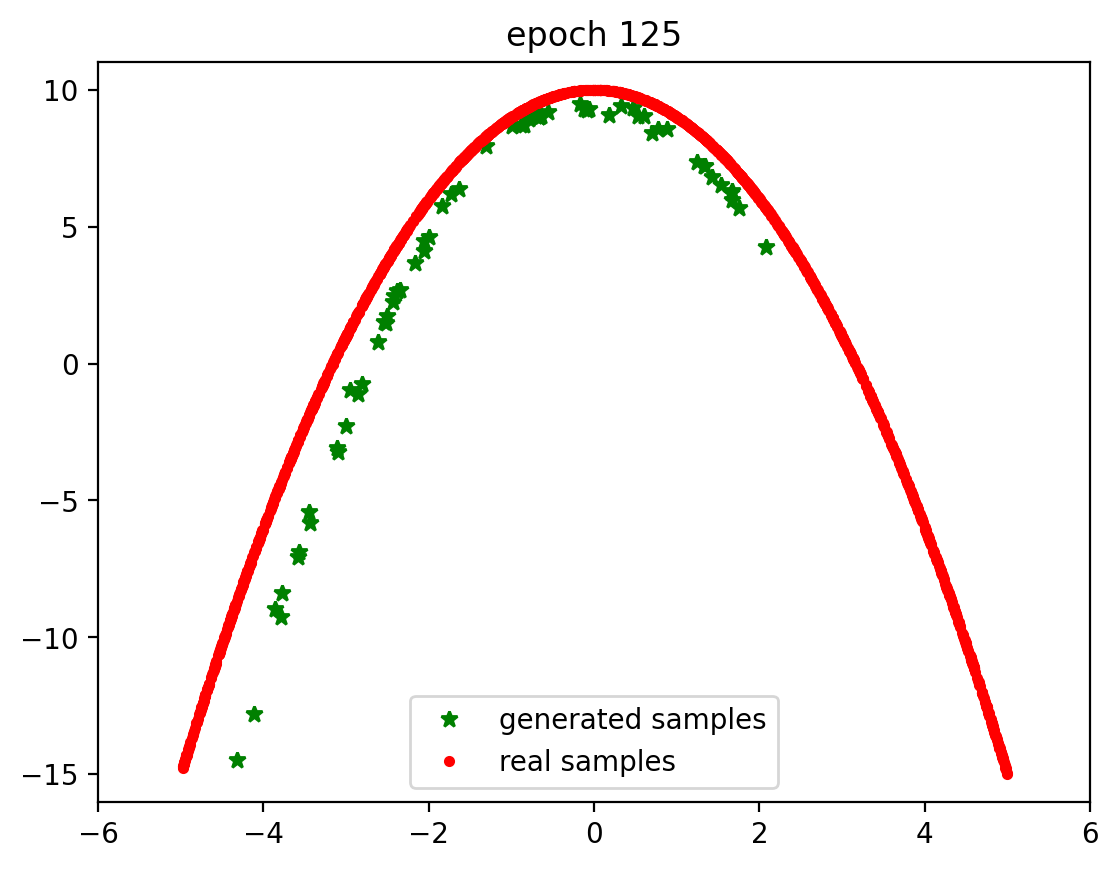

at epoch 149, G loss: 0.8407623537125126, D loss 1.283933577998992


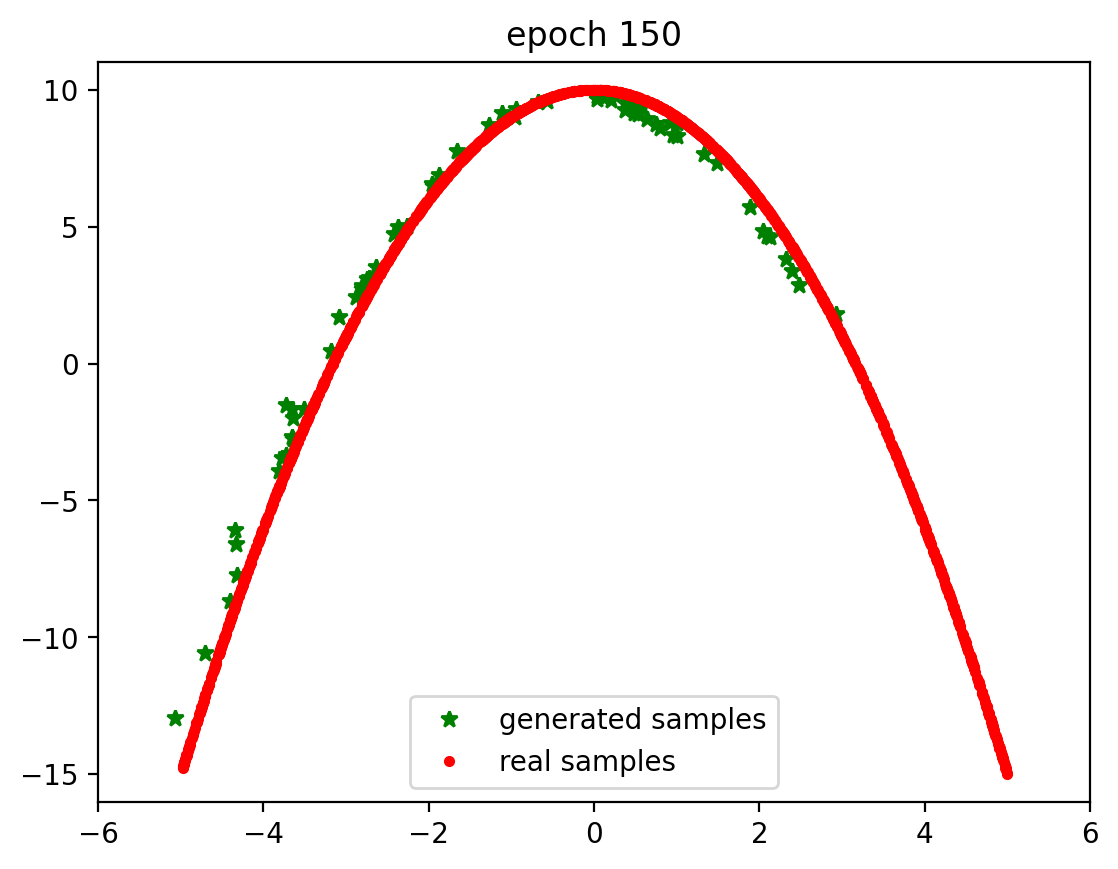

at epoch 174, G loss: 0.8512027494369014, D loss 1.3095236747495589


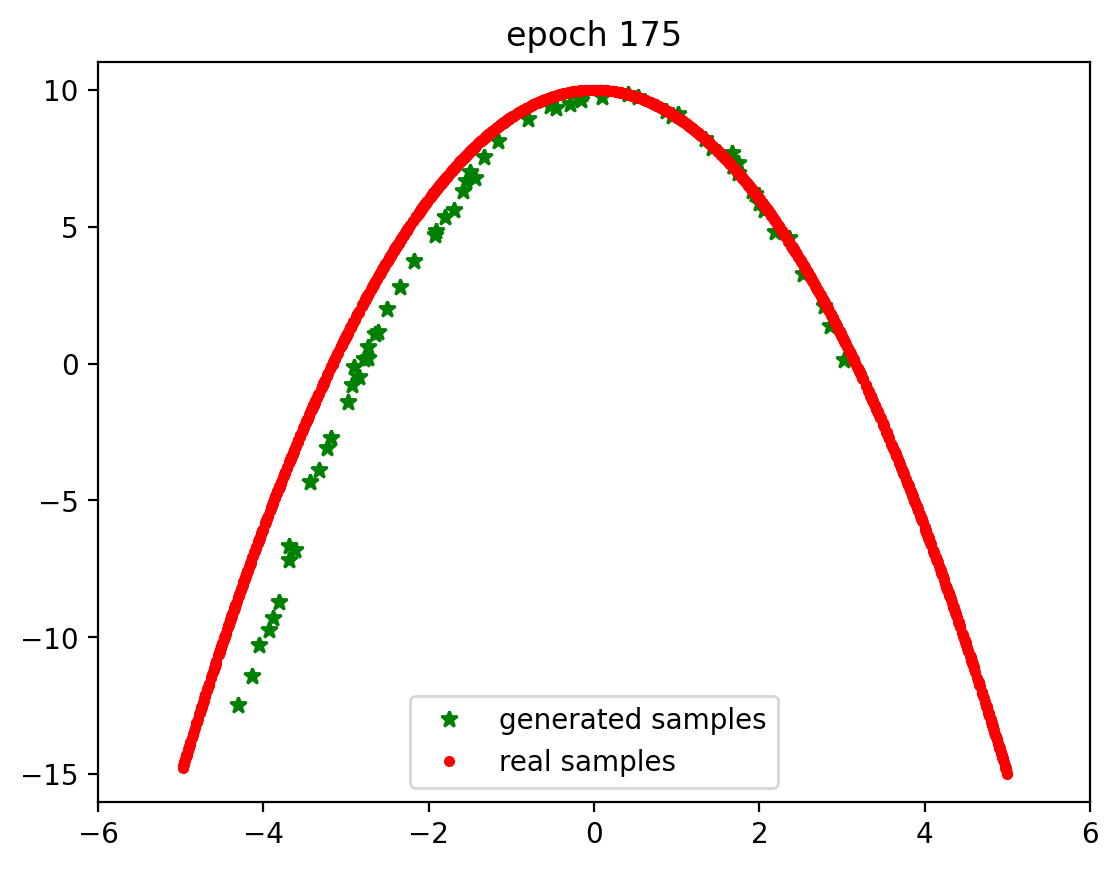

at epoch 199, G loss: 0.9230622322328629, D loss 1.3275100954117314


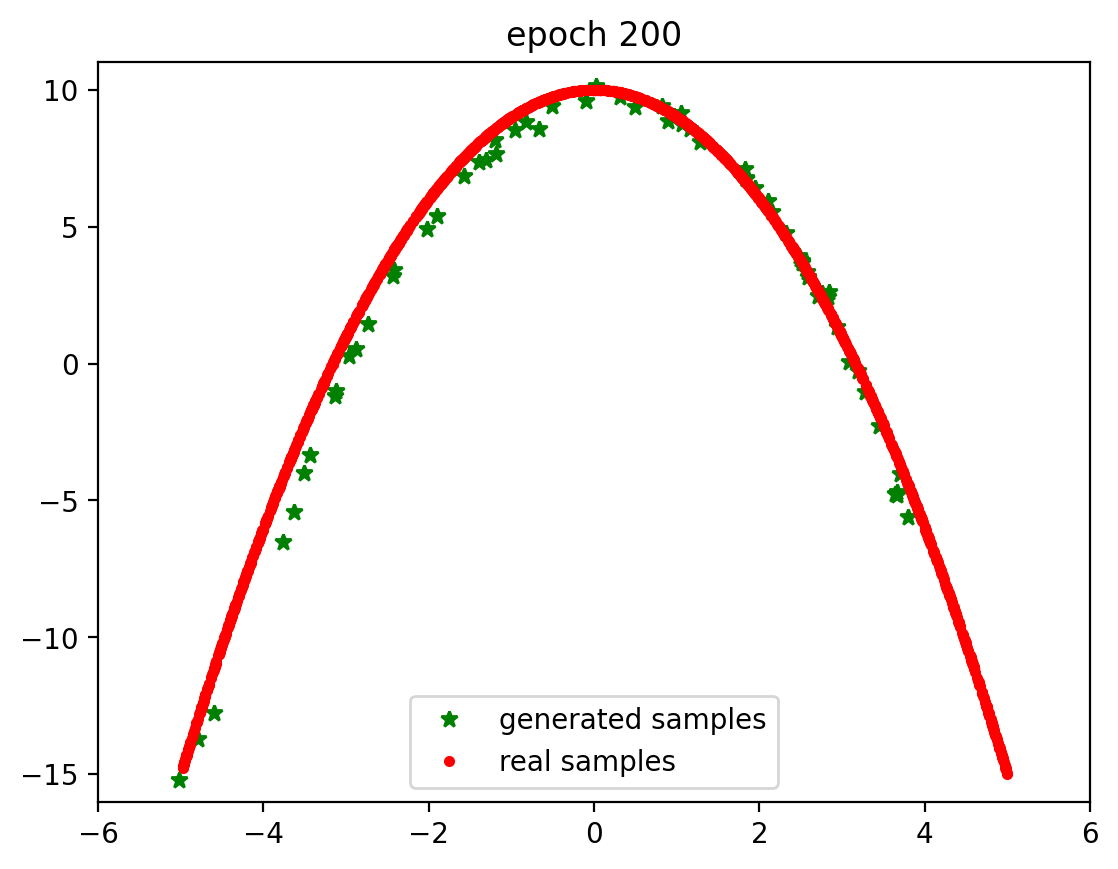

at epoch 224, G loss: 0.8372364044189453, D loss 1.373567150485131


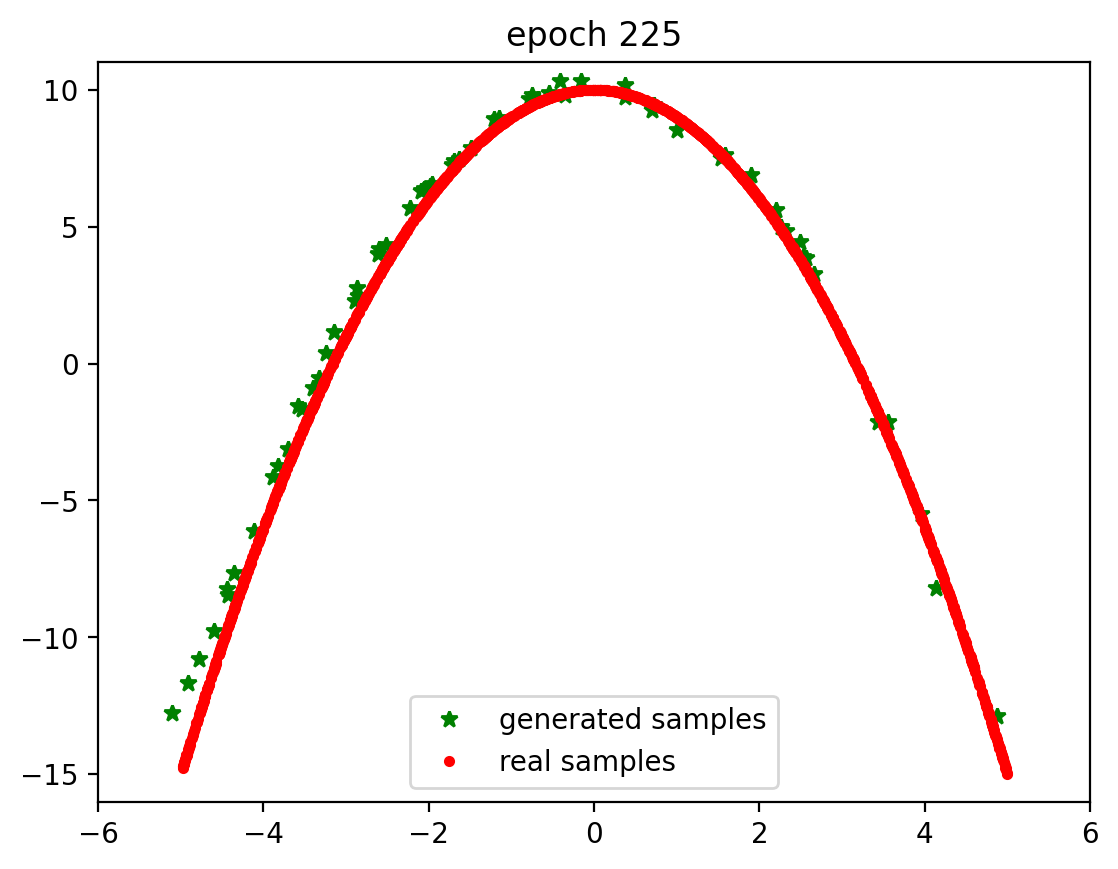

at epoch 249, G loss: 0.8107118914204259, D loss 1.3847167722640499


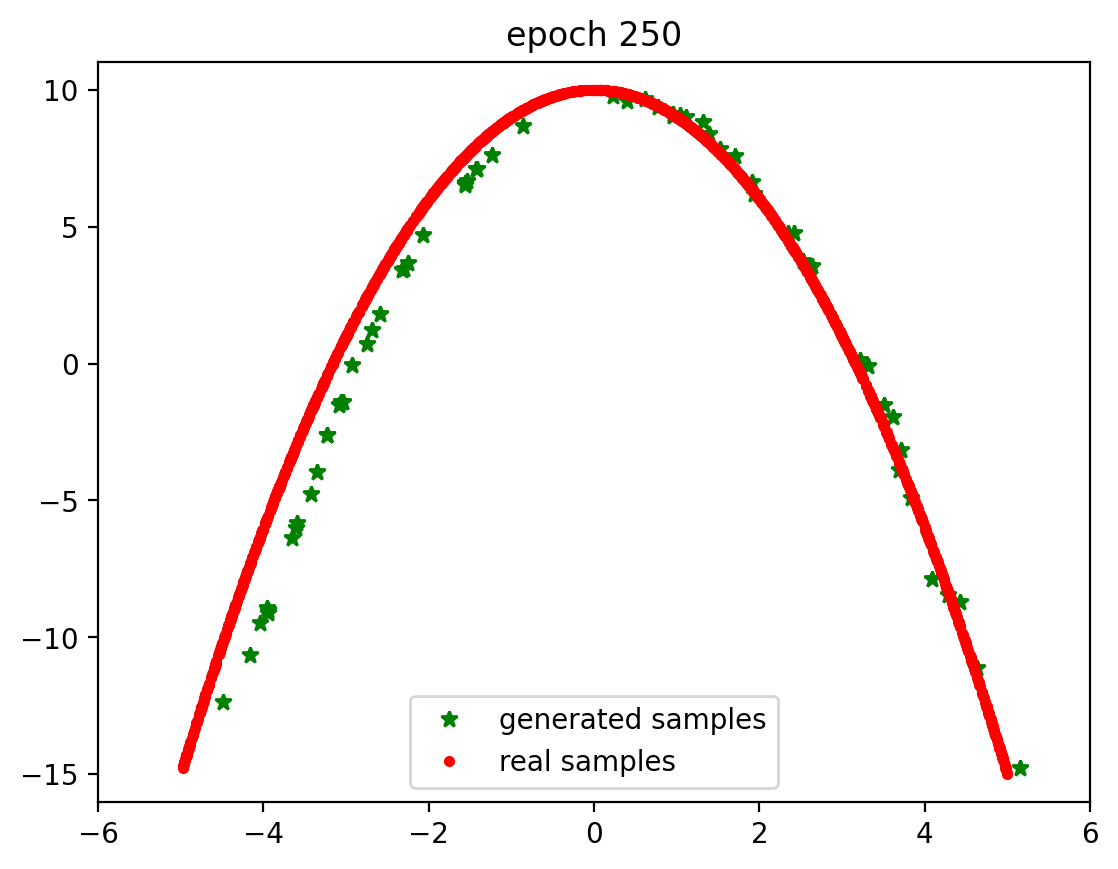

at epoch 274, G loss: 0.886719488328503, D loss 1.3546386226530998


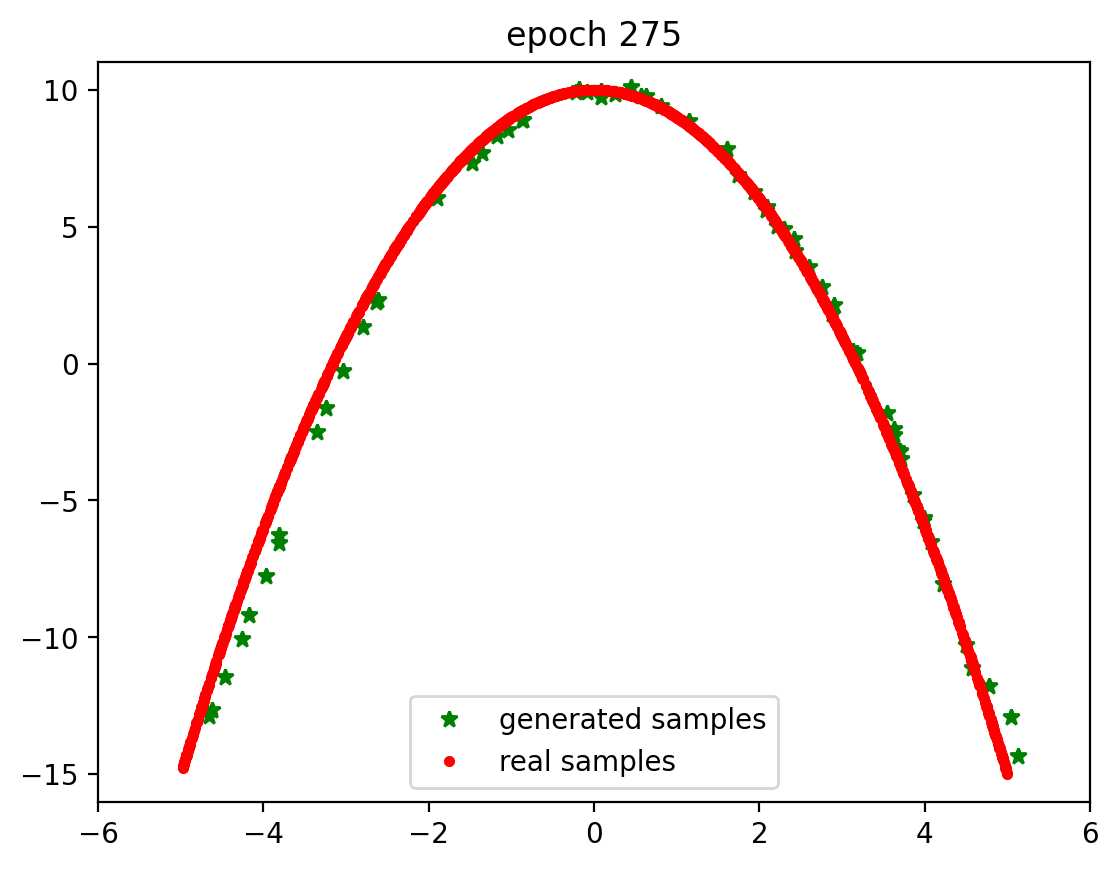

at epoch 299, G loss: 0.8639673417614352, D loss 1.361112779186618


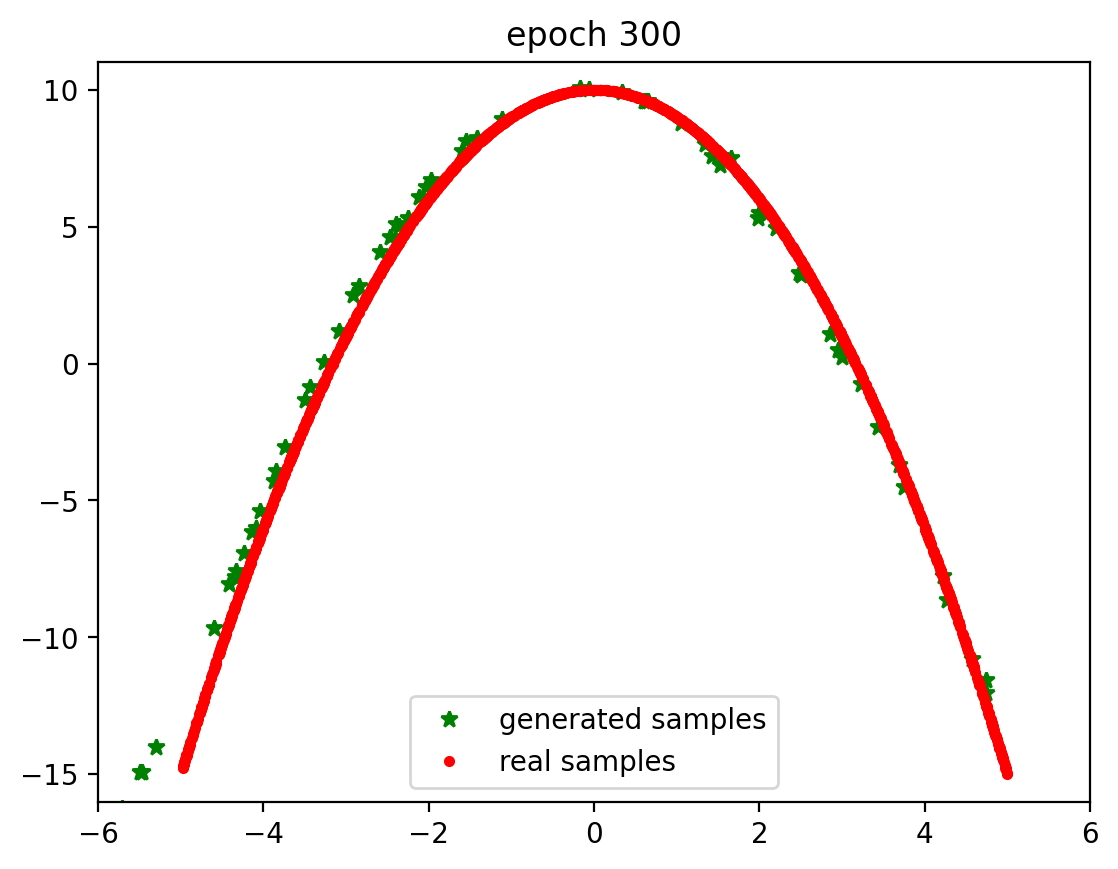

In [13]:
for epoch in range(300):
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n)

## 3.2. Save and Use the Trained Model

In [14]:
scripted = torch.jit.script(G) 
scripted.save('files/invertedU.pt') 

In [15]:
new_G=torch.jit.load('files/invertedU.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [16]:
noise=torch.randn((200,2)).to(device)
new_data=new_G(noise) 

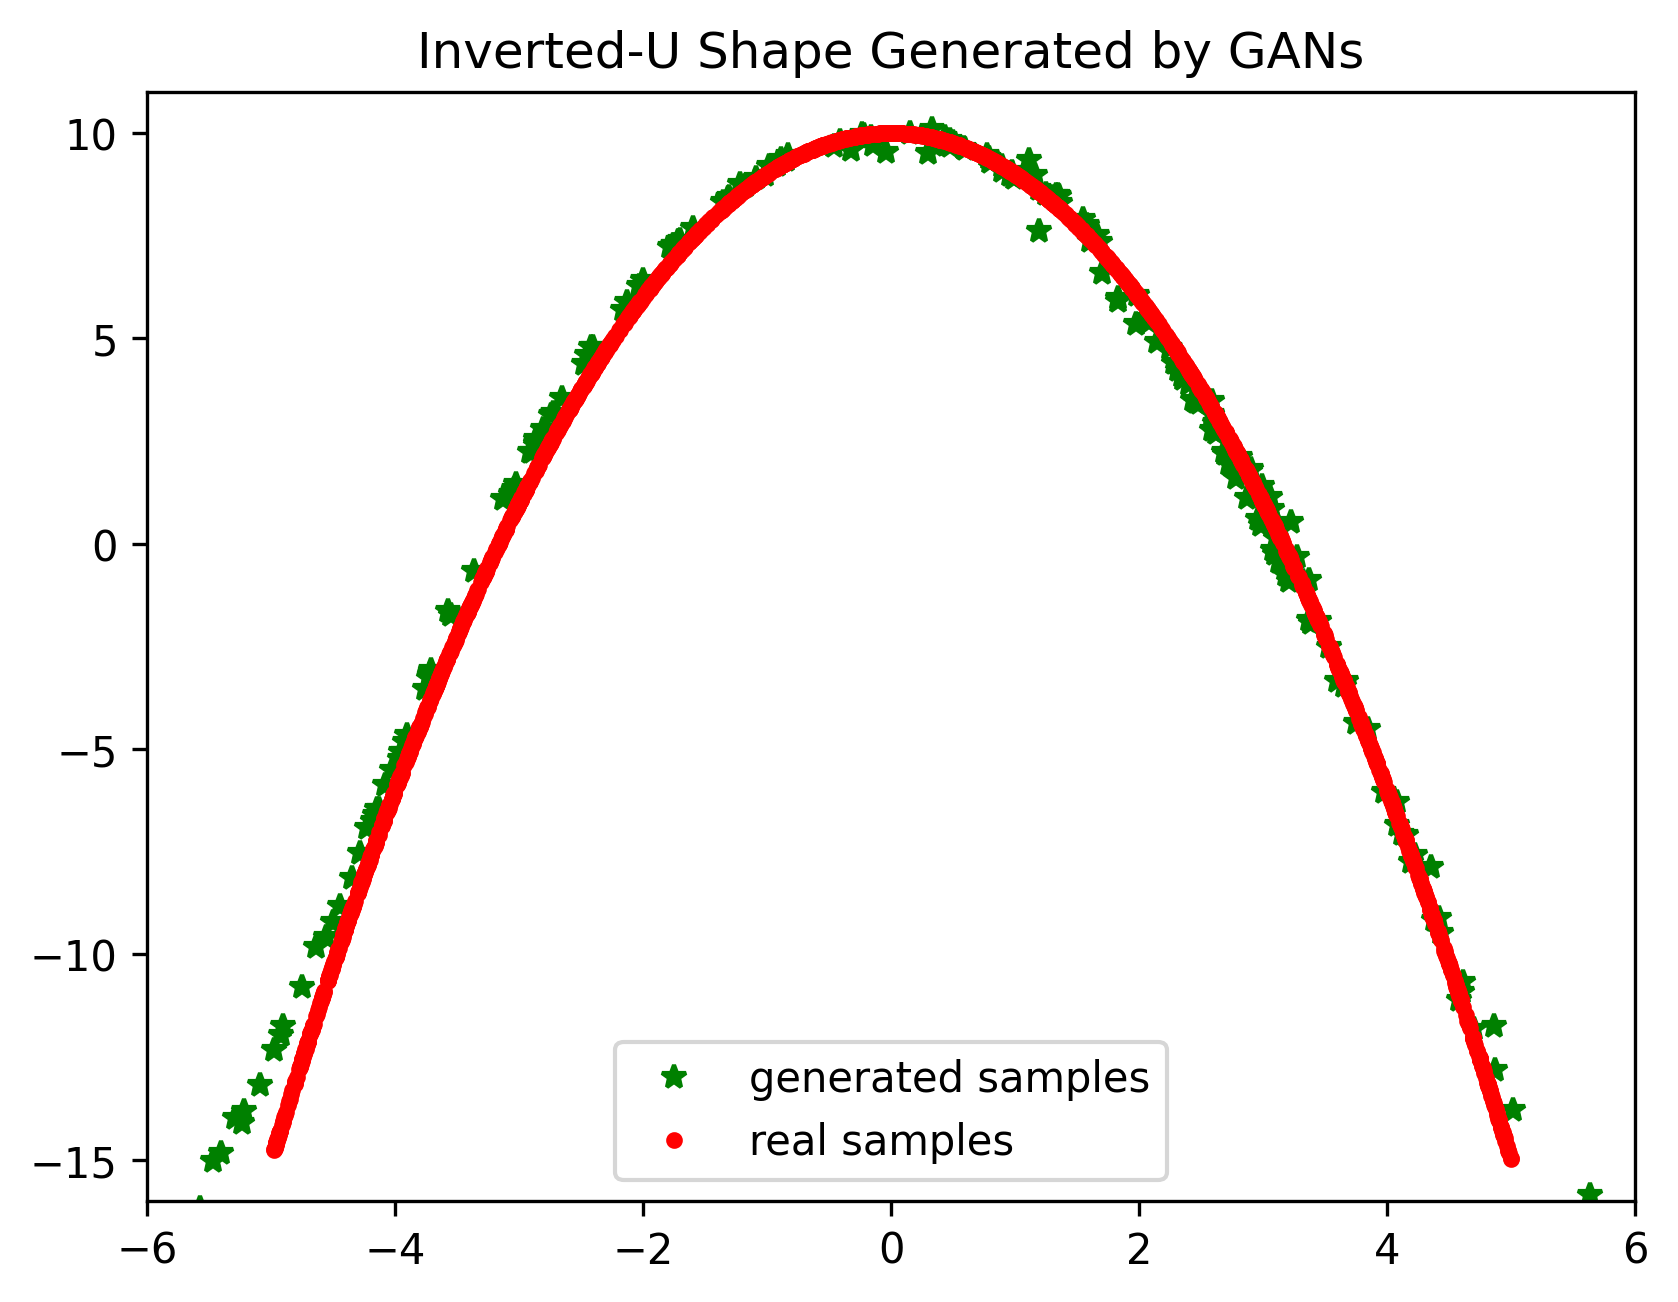

In [17]:
fig=plt.figure(dpi=300)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(-6,6)
plt.ylim(-16,11)
plt.legend()
plt.show()

# 4	Representing Multiples of Five with One-Hot Variables

## 4.1. What Are One-Hot Variables?

In [18]:
def onehot_encoder(position,depth):
    onehot=torch.zeros((depth,))
    onehot[position]=1
    return onehot

In [19]:
print(onehot_encoder(1,5))

tensor([0., 1., 0., 0., 0.])


## 4.2. Converting An Integer to A Pair of One-Hots

In [20]:
def int_to_onehots(number):
    quotient=number//5
    remainder=number%5
    onehot_quotient=onehot_encoder(quotient,20)    #A
    onehot_remainder=onehot_encoder(remainder,5)    #B
    combined=torch.cat(
        [onehot_quotient,
          onehot_remainder])    #C
    return combined

In [21]:
onehots75=int_to_onehots(75)
print(onehots75)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 0.])


## 4.3. Convert A Pair of One-Hots into An Integer

In [22]:
def onehots_to_int(onehots):
    onehot_quotient=onehots[:20]
    quotient=torch.argmax(onehot_quotient)    #A
    onehot_remainder=onehots[-5:]    
    remainder=torch.argmax(onehot_remainder)    #B
    number=5*quotient+remainder    #C
    return number.item()

In [23]:
print(onehots_to_int(onehots75))

75


# 5.  GANs to Generate Patterns 

## 5.1. Create A Batch of Training Data

In [24]:
import random

def gen_sequence():
    indices = random.sample(range(10), 10)
    values = torch.tensor(indices)*5
    return values     

In [25]:
sequence=gen_sequence()
print(sequence)

tensor([45, 15,  5, 25, 20,  0, 40, 10, 35, 30])


The values are all multiples of five. Next, we convert each number to a pair of one-hot variables so that we can feed them to the neural network later. 

In [26]:
import numpy as np

def gen_batch():
    sequence=gen_sequence()    #A
    batch=[int_to_onehots(i).numpy() for i in sequence]    #B
    batch=np.array(batch)
    return torch.tensor(batch)
batch=gen_batch()
print(batch)

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,

In [27]:
def data_to_num(data):
    multiple=torch.argmax(data[:,:20],dim=-1)    #A
    remainder=torch.argmax(data[:,20:],dim=-1)    #B
    num=multiple*5+remainder    #C
    return num
numbers=data_to_num(batch)    #D
print(numbers)

tensor([10, 45, 30, 35, 20, 15, 40,  5, 25,  0])


## 5.2. GANs for Pattern Generation

In [28]:
D=nn.Sequential(
    nn.Linear(25,1),
    nn.Sigmoid()).to(device)

In [29]:
G=nn.Sequential(
    nn.Linear(100,25),
    nn.ReLU()).to(device)

In [30]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

## 5.3. Train the GANs for Pattern Generation

In [31]:
from utils.ch03util import train_D_G    #A

for i in range(1000):
    gloss=0
    dloss=0
    generated_data=train_D_G(D,G,loss_fn,optimD,optimG)    #B     
    if i % 50 == 0:
        print(data_to_num(generated_data))    #C

tensor([ 4, 11, 91, 66, 66, 86, 10, 59, 56, 49], device='cuda:0')
tensor([41, 68, 32, 35, 67, 36, 78, 42, 47, 74], device='cuda:0')
tensor([36,  4, 55, 57, 75, 67, 35, 57, 45, 63], device='cuda:0')
tensor([30,  2, 48,  4, 21, 25,  4, 35, 73,  2], device='cuda:0')
tensor([55, 36, 30,  1, 53, 33, 68, 68,  8, 65], device='cuda:0')
tensor([31, 45,  5, 48,  1, 50, 55, 38,  0, 35], device='cuda:0')
tensor([ 1, 45,  0, 92,  0, 55, 65, 55, 38,  6], device='cuda:0')
tensor([37, 48,  5, 38, 35, 45, 49, 38, 57, 58], device='cuda:0')
tensor([65, 68,  0, 46,  5, 56,  0, 45,  5, 48], device='cuda:0')
tensor([21, 37, 55, 65, 20, 38, 35, 45, 30, 31], device='cuda:0')
tensor([45, 35, 38, 31, 30,  8, 30, 68,  1, 55], device='cuda:0')
tensor([46,  5, 45, 33, 45, 45, 30, 45, 35, 35], device='cuda:0')
tensor([31, 45, 35, 65, 35, 30, 35,  8, 35, 45], device='cuda:0')
tensor([35, 35, 45, 45, 20, 30, 35, 45, 20, 30], device='cuda:0')
tensor([45, 40,  3, 35, 45, 45, 83, 35, 33, 35], device='cuda:0')
tensor([45

## 5.4. Save and Use the Trained Model

In [32]:
# Export to TorchScript
scripted = torch.jit.script(G) 

scripted.save('files/num_gen.pt') 

In [33]:
new_G=torch.jit.load('files/num_gen.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
)

In [34]:
# obtain inputs from the latent space
noise=torch.randn((10,100)).to(device)
# feed the input to the generator 
new_data=new_G(noise) 
print(data_to_num(new_data))

tensor([20, 15, 40, 20, 45, 40, 35, 15,  0, 35], device='cuda:0')
